<a href="https://colab.research.google.com/github/howsmyanimeprofilepicture/nlp-play-ground/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade diffusers accelerate transformers -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.2 MB/s eta 0:00:00


In [ ]:
from diffusers import DiffusionPipeline
from transformers import PreTrainedTokenizerBase
import torch
import torch.nn.functional as F

In [ ]:
from typing import NamedTuple, List
import torch
from transformers import PreTrainedTokenizerBase
from diffusers import DiffusionPipeline

class SearchResult(NamedTuple):
    embed_table: torch.Tensor
    token_ids: torch.Tensor
    tokens: List[str]
    Similarity: torch.Tensor

def is_eng(s: str) -> bool:
    """source: https://stackoverflow.com/questions/27084617/detect-strings-with-non-english-characters-in-python"""
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

def get_valid_token_ids(tokenizer: PreTrainedTokenizerBase,
                        min_length: int = 3):


    valid_token_ids = []
    unvalid_token_ids = []
    for token_id in range(tokenizer.vocab_size):
        token: str = tokenizer.convert_ids_to_tokens(token_id)
        if (token.endswith("</w>")
            and is_eng(token.replace("</w>", ""))
            and len(token.replace("</w>", "")) > min_length
            and token.replace("</w>", "").isalpha()) :
            valid_token_ids.append(token_id)
        else:
            unvalid_token_ids.append(token_id)
    return (valid_token_ids,
            unvalid_token_ids)



class Similarity:
    def __init__(self,
                 embed_tables: torch.Tensor,
                 tokenizer: PreTrainedTokenizerBase ) -> None:
        assert isinstance(tokenizer, PreTrainedTokenizerBase)
        self.embed_tables = embed_tables
        self.tokenizer = tokenizer
        (self.valid_token_ids,
         self.unvalid_token_ids,
         ) = get_valid_token_ids(tokenizer)
        self.vocab_size, self.emb_dim = self.embed_tables.size()
        assert tokenizer.vocab_size == self.vocab_size

    @staticmethod
    def from_diffusers_pipeline(pipeline: DiffusionPipeline):
        assert isinstance(pipeline, DiffusionPipeline)

        embeding_layer_parmas = [*(
            pipeline.text_encoder
                .text_model
                .embeddings
                .token_embedding
                .parameters()
        )]
        assert len(embeding_layer_parmas) == 1
        embed_tables = embeding_layer_parmas[0].detach()

        return Similarity(embed_tables,
                          pipeline.tokenizer)

    def get_embed(self, word: str) -> torch.Tensor:
        encoded = self.tokenizer.encode(word)
        assert len(encoded) == 3, (
            f"The token must be single, but your token ('{word}') seems NOT single"
        )

        _, token_id , _ = encoded

        return self.embed_tables[token_id]

    def search(self,
                word: str,
                               k: int = 10):
        embed: torch.Tensor = self.get_embed(word)
        similarities = (
            (embed[None, :] * self.embed_tables).sum(dim=1)/
            ((embed**2).sum()*(self.embed_tables**2).sum(1))**(0.5)
        )
        similarities[self.unvalid_token_ids] = 0.
        token_ids = similarities.argsort(descending=True)[:k]
        return SearchResult(self.embed_tables[token_ids],
                token_ids,
                self.tokenizer.convert_ids_to_tokens(token_ids),
                similarities[token_ids])

    def get_sim_dict(self,
                           word: str,
                           k: int = 10):
        _, __, tokens, sims = self.search(word, k)
        return {
            token.replace("</w>", "") : sim.item()
            for token, sim in zip(tokens, sims)
        }




In [ ]:

from diffusers import DiffusionPipeline
from transformers import PreTrainedTokenizerBase
import torch
import torch.nn.functional as F



def create_images(word: str, pipeline: DiffusionPipeline):
    return pipeline(word).images[0]



if not torch.cuda.is_available():
    print("diffusers library is only availiable in the env that supports the CUDA! However, your env doesn't support CUDA.... T.T ;;;")



In [ ]:
pipeline = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
)
pipeline.to("cuda")



simil = Similarity.from_diffusers_pipeline(pipeline)

# embs, ids, tokens, sims = simil.search("music", 5000)



`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
import random
import matplotlib.pyplot as plt

In [ ]:
class Quiz:
    def __init__(self, word: str, N: int = 30):

        self.N= N
        self.word = word
        self.similarities = self.get_similarities()


    def hint(self):

        i = random.randint(0, self.N-1)
        word, sim = self.similarities[i]
        fig, ax = plt.subplots()
        img = create_images(word, pipeline)
        ax.imshow(img)
        ax.set_title(f"similarity: {sim}")
        plt.show()

    def __call__(self):
        self.hint()

    def get_similarities(self, ):
        cos_sims = []
        for w, cos_sim in simil.get_sim_dict(
            self.word,
            self.N+30
        ).items():
            if cos_sim > 0.15 :
                continue
            cos_sims.append((w, cos_sim, ))
            if len(cos_sims) >= self.N:
                break
        return cos_sims



In [ ]:
q = Quiz("whale", N=30)

In [ ]:
q.similarities

[('catfish', 0.1483154296875),
 ('saur', 0.147216796875),
 ('penguins', 0.146484375),
 ('bunnies', 0.14599609375),
 ('shark', 0.1458740234375),
 ('dick', 0.145751953125),
 ('turtle', 0.1456298828125),
 ('dolphin', 0.1456298828125),
 ('knights', 0.1444091796875),
 ('wesome', 0.1435546875),
 ('bear', 0.1416015625),
 ('penguin', 0.1416015625),
 ('peninsula', 0.140625),
 ('holic', 0.1402587890625),
 ('mullet', 0.1402587890625),
 ('dreamliner', 0.1402587890625),
 ('elves', 0.14013671875),
 ('monkey', 0.1392822265625),
 ('pier', 0.1390380859375),
 ('necks', 0.1390380859375),
 ('owls', 0.138671875),
 ('bars', 0.1363525390625),
 ('goat', 0.1353759765625),
 ('beef', 0.134521484375),
 ('jellyfish', 0.1341552734375),
 ('gull', 0.1329345703125),
 ('chained', 0.1328125),
 ('hulk', 0.132080078125),
 ('mammal', 0.132080078125),
 ('jonah', 0.1317138671875)]

  0%|          | 0/50 [00:00<?, ?it/s]

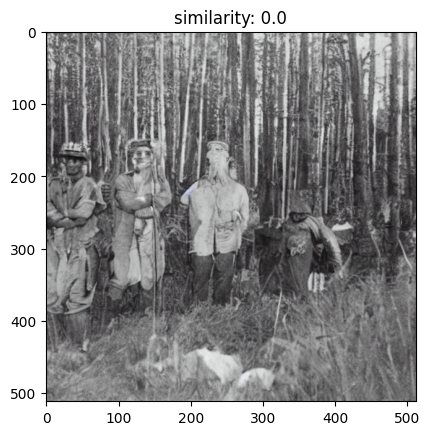

In [ ]:
q()

  0%|          | 0/50 [00:00<?, ?it/s]

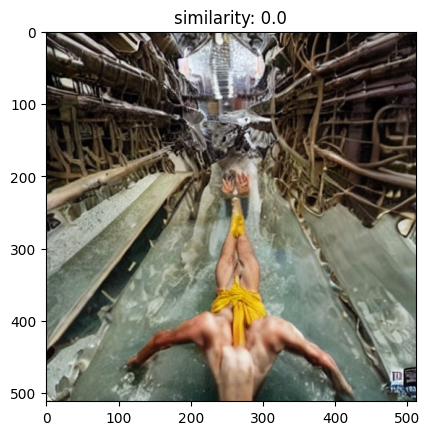

In [ ]:
q()

  0%|          | 0/50 [00:00<?, ?it/s]

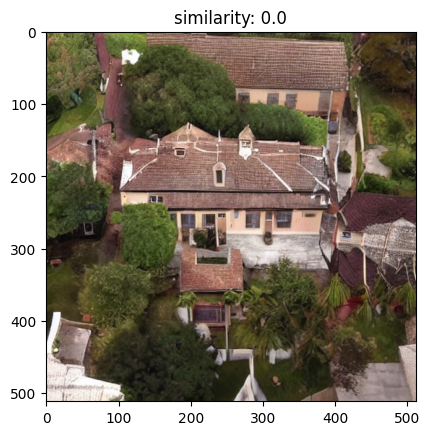

In [ ]:
q()

In [ ]:
q = Quiz("moon", N=30)

In [ ]:
q.similarities

[('tree', 0.14990234375),
 ('luna', 0.1495361328125),
 ('passport', 0.1448974609375),
 ('honeymoon', 0.144775390625),
 ('planet', 0.144287109375),
 ('money', 0.1431884765625),
 ('evening', 0.1409912109375),
 ('nest', 0.1397705078125),
 ('jerusalem', 0.139404296875),
 ('mood', 0.136962890625),
 ('love', 0.13671875),
 ('halo', 0.1353759765625),
 ('cloud', 0.134765625),
 ('amour', 0.1346435546875),
 ('woman', 0.13330078125),
 ('noon', 0.1324462890625),
 ('peace', 0.1322021484375),
 ('birth', 0.130126953125),
 ('bell', 0.12939453125),
 ('chatting', 0.12939453125),
 ('dusk', 0.129150390625),
 ('rainfall', 0.12890625),
 ('mountains', 0.128662109375),
 ('pear', 0.1285400390625),
 ('thumb', 0.1279296875),
 ('twilight', 0.12744140625),
 ('snowfall', 0.12744140625),
 ('girl', 0.1273193359375),
 ('dawn', 0.127197265625),
 ('banana', 0.127197265625)]

  0%|          | 0/50 [00:00<?, ?it/s]

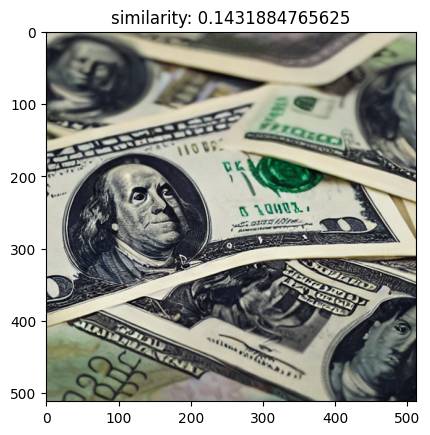

In [ ]:
q()

  0%|          | 0/50 [00:00<?, ?it/s]

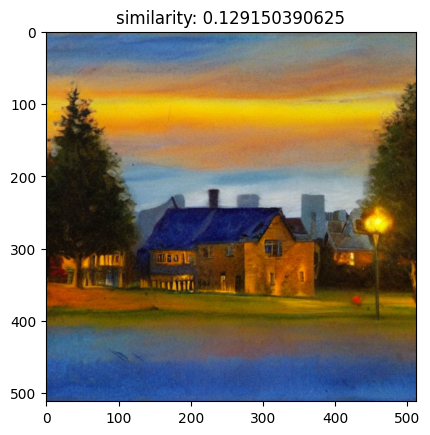

In [ ]:
q()